In [14]:
!pip install libauc==1.2.0
!pip install medmnist
!pip install torchio

In [15]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

from libauc.models import resnet18
from libauc.sampler import DualSampler
from libauc.metrics import auc_prc_score

import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image, ImageFilter
from torchio import Image

In [16]:
from libauc.losses import AUCMLoss, CrossEntropyLoss
from libauc.optimizers import PESG, Adam
from PIL import Image
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [17]:
data_flag = 'pneumoniamnist'
download = True
BATCH_SIZE = 128
lr = 0.001
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

In [18]:
print(info)
print(n_channels)
print(n_classes)
print(DataClass)

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

In [82]:
from torchio.transforms import RandomAffine, RandomFlip, RandomNoise, RandomGamma
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=28, crop_size=24, mode='train', kernel_size=3):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode


        self.transform_train = transforms.Compose([
                                                    transforms.ToTensor(),
                                                    transforms.Resize((image_size, image_size)),
                                                    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.2), shear=0.2),
                                                    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.5),
                                                    transforms.RandomHorizontalFlip(p=0.5),
                                                    transforms.RandomVerticalFlip(p=0.5),
                                                    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
                                                ])

        self.transform_test = transforms.Compose([
                             transforms.ToTensor(),

                             transforms.Resize((image_size, image_size)),
                              ])



        self.pos_indices = np.flatnonzero(targets==1)
        self.pos_index_map = {}
        for i, idx in enumerate(self.pos_indices):
            self.pos_index_map[idx] = i

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))

        if self.mode == 'train':
           idx = self.pos_index_map[idx] if idx in self.pos_indices else -1


           image = self.transform_train(image)
        else:
           image = self.transform_test(image)
        return idx, image, target

In [20]:
train_dataset = DataClass(split='train', download=download)
print(train_dataset[0])
test_dataset = DataClass(split='test', download=download)
print(test_dataset[0])

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
(<PIL.Image.Image image mode=L size=28x28 at 0x7F726C36EB60>, array([1]))
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
(<PIL.Image.Image image mode=L size=28x28 at 0x7F726C36EB60>, array([1]))


In [21]:
train_images = np.array([np.asarray(image) for (image, target) in train_dataset])
train_labels = np.array([target for (image, target) in train_dataset])
print(type(train_images[0]))

<class 'numpy.ndarray'>


In [22]:
test_images = np.array([np.asarray(image) for (image, target) in test_dataset])
test_labels = [target for (image, target) in test_dataset]
print(type(test_images[0]))

<class 'numpy.ndarray'>


In [23]:
test_images[0].shape

(28, 28)

In [52]:
test_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, array([1]))

In [24]:
batch_size = 32
sampling_rate = 0.5

trainSet = ImageDataset(train_images, train_labels)
trainSet_eval = ImageDataset(train_images, train_labels, mode='test')
testSet = ImageDataset(test_images, test_labels, mode='test')

sampler = DualSampler(trainSet, batch_size, sampling_rate=sampling_rate)
train_loader = torch.utils.data.DataLoader(trainSet, batch_size=batch_size, sampler=sampler, num_workers=2)
train_loader_at_eval = torch.utils.data.DataLoader(trainSet_eval, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testSet, batch_size=batch_size, shuffle=False, num_workers=2)

In [25]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 624
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pne

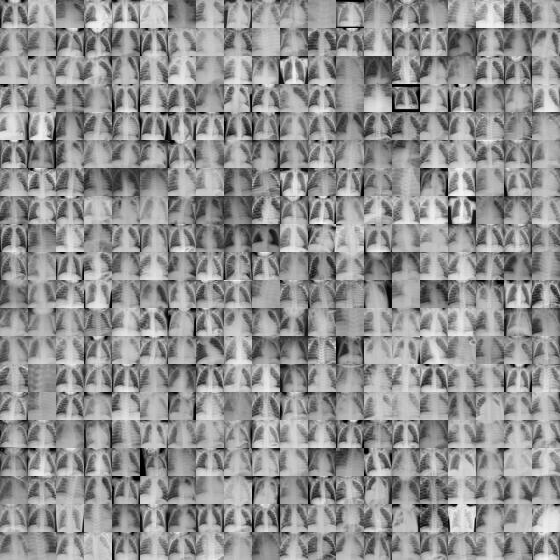

In [26]:
train_dataset.montage(length=20)

In [27]:
lables = train_dataset.labels
cnt1 = 0
cnt0 = 0
for i in range(len(lables)):
  if lables[i][0] == 0:
    cnt0+=1
  else:
    cnt1+=1
print("num of label 0 data",cnt0)
print("num of label 1 dat",cnt1)
print("minority data percent",cnt0*100/(cnt0+cnt1))

num of label 0 data 1214
num of label 1 dat 3494
minority data percent 25.78589634664401


In [28]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
import warnings
warnings.filterwarnings("ignore")
import os, random
def set_all_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [29]:
SEED = 123
BATCH_SIZE = 32
lr = 0.001
weight_decay = 1e-5
num_classes=1

model = models.resnet18(pretrained=True)

input_channel = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(input_channel, 128),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 nn.Linear(128, 32),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.1),
                                 nn.Linear(32, num_classes),
                                 nn.Sigmoid()
                                 )


model = model.to(device)

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, patience=3,  verbose=True, factor=0.5,
                              threshold=0.001, min_lr=0.00001, mode = 'max')

best_val_auc = 0

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 51.3MB/s]


In [30]:
for epoch in range(10):
    for idx, (index, data, labels) in enumerate(train_loader):
      train_data, train_labels = data.to(device), labels.to(device)
      train_data=train_data.repeat(1,3,1,1)
      y_pred = model(train_data)

      loss = criterion(y_pred, train_labels.float())
      print("Training Loss= ", loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f'Validating epoch: {epoch+1} Loss: {loss.item()}')
    model.eval()
    val_auc_mean = 0
    with torch.no_grad():
         val_pred = []
         val_true = []
         for jdx, (index, data, targets) in enumerate(train_loader_at_eval):
             val_data, val_labels = data.to(device), targets.to(device)
             val_data=val_data.repeat(1,3,1,1)
             y_pred = model(val_data)
             val_pred.append(y_pred.cpu().detach().numpy())
             val_true.append(val_labels.cpu().detach().numpy())
         val_true = np.concatenate(val_true)
         val_pred = np.concatenate(val_pred)
         val_auc_mean =  roc_auc_score(val_true, val_pred)
         if best_val_auc < val_auc_mean:
            best_val_auc = val_auc_mean
            torch.save(model.state_dict(), 'ce_pmnist_pretrained_model.pth')
         print ('Epoch=%s, BatchID=%s, Val_AUC=%.4f, Best_Val_AUC=%.4f'%(epoch, idx, val_auc_mean, best_val_auc) )
    scheduler.step(val_auc_mean)

Training Loss=  0.6949868202209473
Training Loss=  0.6933528780937195
Training Loss=  0.6532671451568604
Training Loss=  0.6469088196754456
Training Loss=  0.5502206087112427
Training Loss=  0.5214088559150696
Training Loss=  0.44590720534324646
Training Loss=  0.37222376465797424
Training Loss=  0.30819225311279297
Training Loss=  0.33362314105033875
Training Loss=  0.4077383875846863
Training Loss=  0.19926686584949493
Training Loss=  0.3850362300872803
Training Loss=  0.42914873361587524
Training Loss=  0.36599984765052795
Training Loss=  0.4653489887714386
Training Loss=  0.4028393030166626
Training Loss=  0.19339337944984436
Training Loss=  0.5877255201339722
Training Loss=  0.2889007329940796
Training Loss=  0.23242449760437012
Training Loss=  0.4040687680244446
Training Loss=  0.3262863755226135
Training Loss=  0.27554282546043396
Training Loss=  0.19560948014259338
Training Loss=  0.3639572262763977
Training Loss=  0.43807700276374817
Training Loss=  0.4138578176498413
Training

In [31]:
    print(f'Testing ...')
    PATH = 'ce_pmnist_pretrained_model.pth'
    model_state_dict = torch.load(PATH)
    model.load_state_dict(model_state_dict)
    with torch.no_grad():
         test_pred = []
         test_true = []
         for jdx, (index, data, targets) in enumerate(test_loader):
             test_data, test_labels = data.to(device), targets.to(device)
             test_data=test_data.repeat(1,3,1,1)
             y_pred = model(test_data)
             test_pred.append(y_pred.cpu().detach().numpy())
             test_true.append(test_labels.cpu().detach().numpy())

         test_true = np.concatenate(test_true)
         test_pred = np.concatenate(test_pred)
         test_auc_mean =  roc_auc_score(test_true, test_pred)
         print('Test_AUC=%.4f'%( test_auc_mean))

Testing ...
Test_AUC=0.9584
